In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib
data_dir = "ISL/ISL/Training"
data_dir = pathlib.Path(data_dir)
eval_dir = "ISL/ISL/Testing"
eval_dir = pathlib.Path(eval_dir)

### Testing Split and Augmentation

In [3]:
# ImageDataGenerator
datagen = ImageDataGenerator(
#     validation_split=0.2,
         rotation_range=20, # rotation
         width_shift_range=0.2, # horizontal shift
         height_shift_range=0.2, # vertical shift
         zoom_range=0.2, # zoom
         shear_range=0.1,
         fill_mode="nearest",
         horizontal_flip=True, # horizontal flip
         brightness_range=[0.2,1.2]) # brightness

test_datagen=ImageDataGenerator(validation_split=0.2)
train_ds = datagen.flow_from_directory(data_dir,
                                           class_mode = 'categorical',
                                           target_size = (100, 100),
                                           batch_size=32,
#                                        subset='training',
                                           seed=46)
val_ds = datagen.flow_from_directory(eval_dir,
                                     class_mode = 'categorical',
                                     target_size = (100, 100),
                                     batch_size=32,
#                                           subset='validation',
                                     seed=46)

Found 8089 images belonging to 26 classes.
Found 3003 images belonging to 26 classes.


### Labels

In [4]:
#load labels for further test purposes
def load_labels(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            labels.append(idx)
    labels = np.array(labels)
    return(labels)

uniq_labels = sorted(os.listdir("ISL/ISL/Training"))
labels = load_labels(directory = "ISL/ISL/Testing")

### Declare Metrics

In [5]:
from tensorflow.keras import backend as K
def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

### Implementing DenseNet201

In [6]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(100,100,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

In [7]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(26, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [8]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy',f1, precision,recall])

In [9]:
his = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
253/253 [==============================] - 551s 2s/step - loss: 1.8626 - accuracy: 0.5070 - f1: 0.4281 - precision: 0.6728 - recall: 0.3396 - val_loss: 1.5717 - val_accuracy: 0.5794 - val_f1: 0.5531 - val_precision: 0.6935 - val_recall: 0.4637
Epoch 2/10
253/253 [==============================] - 319s 1s/step - loss: 0.6061 - accuracy: 0.8159 - f1: 0.8091 - precision: 0.8868 - recall: 0.7466 - val_loss: 1.3163 - val_accuracy: 0.6577 - val_f1: 0.6553 - val_precision: 0.7345 - val_recall: 0.5937
Epoch 3/10
253/253 [==============================] - 313s 1s/step - loss: 0.4265 - accuracy: 0.8712 - f1: 0.8690 - precision: 0.9099 - recall: 0.8329 - val_loss: 1.1674 - val_accuracy: 0.7273 - val_f1: 0.7331 - val_precision: 0.7855 - val_recall: 0.6886
Epoch 4/10
253/253 [==============================] - 313s 1s/step - loss: 0.3491 - accuracy: 0.8912 - f1: 0.8903 - precision: 0.9194 - recall: 0.8640 - val_loss: 1.1358 - val_accuracy: 0.7353 - val_f1: 0.7409 - val_precision: 0.7873 -

### Saving the model

In [10]:
model.save('DenseNet201.h5')

### Metrics

In [11]:
Y_pred = model.predict_generator(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 25, 25, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 25, 25, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 25, 25, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 12, 12, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 12, 12, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 12, 12, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 12, 12, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 12, 12, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 12, 12, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 12, 12, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 12, 12, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 12, 12, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 12, 12, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 12, 12, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 6, 6, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 6, 6, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 6, 6, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 6, 6, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 6, 6, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 6, 6, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 6, 6, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 6, 6, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 6, 6, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 6, 6, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 6, 6, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 6, 6, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 6, 6, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 6, 6, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 6, 6, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_1_conv (Conv2D)  (None, 6, 6, 128)    131072      ['conv4_block25_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 6, 6, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 6, 6, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 6, 6, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 6, 6, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 6, 6, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 6, 6, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_block38_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv4_block38_1_conv[0][0]']   
 lization)

 conv4_block42_1_conv (Conv2D)  (None, 6, 6, 128)    200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block42_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 6, 6, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 6, 6, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block47_0_relu (Activati  (None, 6, 6, 1728)  0           ['conv4_block47_0_bn[0][0]']     
 on)      

 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 3, 3, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 3, 3, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 3, 3, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block7_0_bn (BatchNormal  (None, 3, 3, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 3, 3, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 3, 3, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 3, 3, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 3, 3, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 3, 3, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_block11_concat (Concaten  (None, 3, 3, 1248)  0           ['conv5_block10_concat[0][0]',   
 ate)     

 conv5_block15_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 3, 3, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 3, 3, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 3, 3, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block20_0_relu (Activati  (None, 3, 3, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 3, 3, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 3, 3, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_1_relu (Activati  (None, 3, 3, 128)   0           ['conv5_block20_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 3, 3, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 3, 3, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block28_concat (Concaten  (None, 3, 3, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 3, 3, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 3, 3, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block29_1_conv (Conv2D)  (None, 3, 3, 128)    229376      ['conv5_block29_0_relu[0][0]']   
          

 avg_pool (GlobalAveragePooling  (None, 1920)        0           ['relu[0][0]']                   
 2D)                                                                                              
                                                                                                  
 dense (Dense)                  (None, 128)          245888      ['avg_pool[0][0]']               
                                                                                                  
 dense_1 (Dense)                (None, 26)           3354        ['dense[0][0]']                  
                                                                                                  
Total params: 18,571,226
Trainable params: 249,242
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [13]:
#Printing the accuracy of the implemented model on test images
score = model.evaluate(val_ds, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')

Accuracy for test images: 79.887 %


In [14]:
#classification report
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       110
           1       0.05      0.05      0.05       120
           2       0.05      0.05      0.05       100
           3       0.01      0.01      0.01       129
           4       0.03      0.04      0.03       114
           5       0.02      0.01      0.01       115
           6       0.08      0.07      0.07        86
           7       0.04      0.04      0.04       112
           8       0.05      0.07      0.06       117
           9       0.02      0.03      0.03       122
          10       0.02      0.01      0.01       102
          11       0.04      0.04      0.04       143
          12       0.03      0.04      0.04       114
          13       0.02      0.02      0.02       104
          14       0.00      0.00      0.00       129
          15       0.08      0.12      0.09       132
          16       0.05      0.05      0.05       126
          17       0.02    

Text(0.5, 114.0, 'Predicted label')

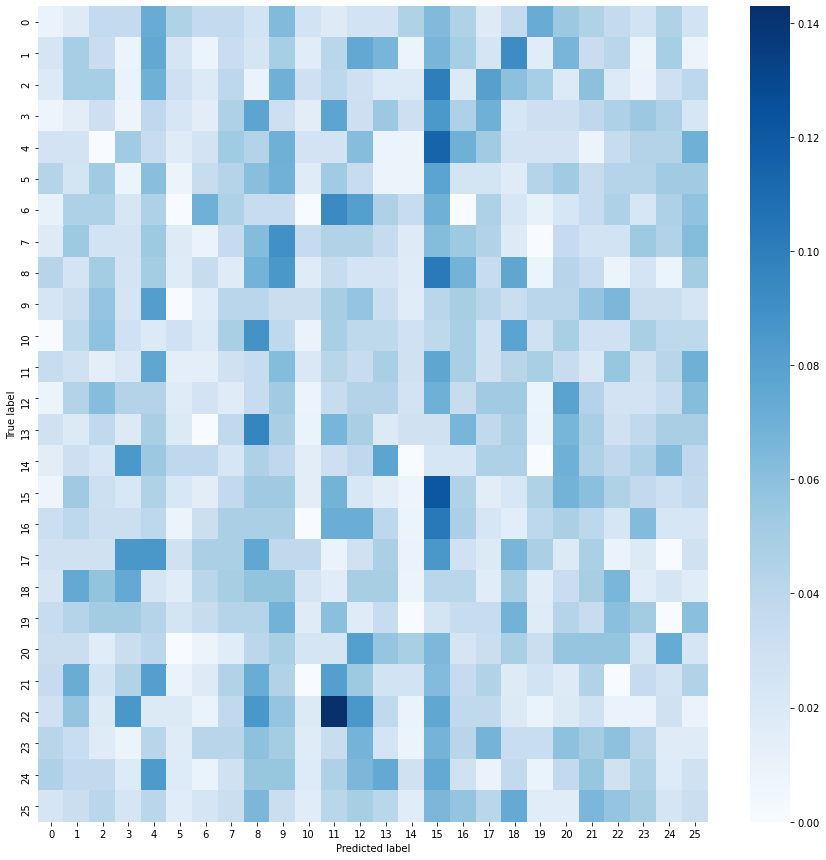

In [15]:
#confusion matrix
cf_mat = confusion_matrix(val_ds.classes, y_pred)
cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15, 15))
sns.heatmap(cf_mat_normalized, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

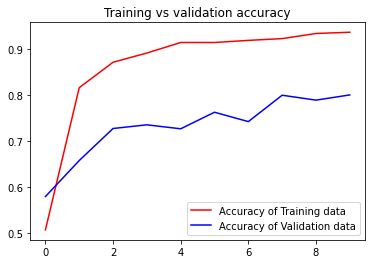

<Figure size 432x288 with 0 Axes>

In [16]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

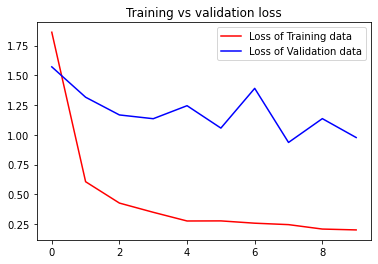

<Figure size 432x288 with 0 Axes>

In [17]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

### Testing

['O']

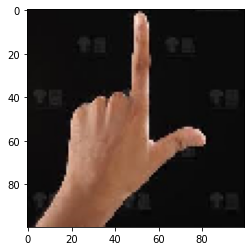

In [18]:
#Creating a dictionary to map each of the indexes to the corresponding number or letter
from keras.preprocessing import image
dict = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",
        11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",
        24:"Y",25:"Z"}


#Predicting images

img = image.load_img("sign_L.jpg", target_size=(100, 100))
x = image.img_to_array(img)
plt.imshow(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = model.predict(image, batch_size=64)
label = [np.argmax(i) for i in classes]
pred_class=[dict[x] for x in label]
pred_class

In [19]:
loss, accuracy, f1_score, precision, recall = model.evaluate(val_ds, verbose=0)

In [20]:
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1_score}")

Test Loss: 1.0228300094604492
Test Accuracy: 0.8001998066902161
Test Precision: 0.8276683688163757
Test Recall: 0.7890686392784119
Test F1 Score: 0.8076013326644897
